**Etape 2 - Modélisation**

**Description des variables**

**0- age :** âge du client

**1- job :** type d'emploi

**2- marital :** statut marital

**3- education :** niveau d'études

**4- default :** le client a-il eu un défaut de paiement sur un crédit ?

**5- balance :** montant des encours détenus par le client

**6- housing :** détention d'un prêt immobilier

**7- loan :** détention d'un prêt personnel

**8- contact :** canal de communication (lors du dernier contact de la campagne en cours)

**9- day :** jour du dernier contact de la campagne en cours

**10- month :** mois du dernier contact de la campagne en cours

**11- duration :** durée (en secondes) du dernier contact de la campagne en cours

**12- campaign :** nombre de contacts effectués au cours de cette campagne et pour ce client (inclut le dernier contact)

**13- pdays :** nombre de jours qui se sont écoulés depuis que le client a été contacté pour la dernière fois lors d'une campagne précédente

**14- previous :** nombre de contacts effectués avant cette campagne et pour ce client

**15- poutcome :** résultat de la campagne marketing précédente

**16- deposit :** le client a-il souscrit à un dépôt à terme?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()  # pour modifier le thème

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

df = pd.read_csv('bank.csv') 
print(df.head())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


**Nettoyage de la base de données**

In [2]:
# Réalisation des modifications évoquées précédemment sur un nouveau dataframe nommé df_clean
df_clean = df

# On renomme les 'unknown' de job en 'other'
df_clean['job'].replace('unknown', 'other', inplace=True)

# On renomme les 'unknown' de education en 'other'
df_clean['education'].replace('unknown', 'other', inplace=True)

# On renomme les 'unknown' de contact en 'other type of contact'
df_clean['contact'].replace('unknown', 'other type of contact', inplace=True)

# On supprime les deux clients ayant participé à la campagne précédente mais n'ayant pas de résultat renseignée à poutcome
df_clean.drop(df_clean.loc[ (df_clean['previous'] > 0)
              & (df_clean['poutcome'] == 'unknown') ].index, inplace=True)
# 2 lignes supprimées

# On renomme les 'unknown' de poutcome en 'not contacted previously'
df_clean['poutcome'].replace('unknown', 'not contacted previously', inplace=True)

# On supprime les clients ayant des valeurs aberrantes dans campaign (campaign >= 10)
df_clean.drop(df_clean.loc[(df_clean['campaign'] >= 10)].index, inplace=True)
# 262 lignes supprimées

# Suppression des variables pdays, previous et day
df_clean.drop(['pdays', 'previous','day'], axis = 1, inplace = True)
print(df_clean.head())

   age         job  marital  education default  balance housing loan  \
0   59      admin.  married  secondary      no     2343     yes   no   
1   56      admin.  married  secondary      no       45      no   no   
2   41  technician  married  secondary      no     1270     yes   no   
3   55    services  married  secondary      no     2476     yes   no   
4   54      admin.  married   tertiary      no      184      no   no   

                 contact month  duration  campaign                  poutcome  \
0  other type of contact   may      1042         1  not contacted previously   
1  other type of contact   may      1467         1  not contacted previously   
2  other type of contact   may      1389         1  not contacted previously   
3  other type of contact   may       579         1  not contacted previously   
4  other type of contact   may       673         2  not contacted previously   

  deposit  
0     yes  
1     yes  
2     yes  
3     yes  
4     yes  


**Nettoyage des variables quali**

In [3]:
# Dataframe spécifique pour la classification
df_classification = df_clean

# Remplacement des 'no' par 0 et des yes par '1'
df_classification.replace(['no','yes'],[0,1], inplace=True)

# Application du One Hot Encoding sur les variables quali restantes
df_classification_categorielles = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
for col in df_classification_categorielles :
    df_classification=df_classification.join(pd.get_dummies(df_classification[col], prefix=col).astype('int64'))

df_classification.drop(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], axis = 1, inplace = True)
    
print(df_classification.info()) # donne des infos générales sur le dataframe
print(df_classification.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10898 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                10898 non-null  int64
 1   default                            10898 non-null  int64
 2   balance                            10898 non-null  int64
 3   housing                            10898 non-null  int64
 4   loan                               10898 non-null  int64
 5   duration                           10898 non-null  int64
 6   campaign                           10898 non-null  int64
 7   deposit                            10898 non-null  int64
 8   job_admin.                         10898 non-null  int64
 9   job_blue-collar                    10898 non-null  int64
 10  job_entrepreneur                   10898 non-null  int64
 11  job_housemaid                      10898 non-null  int64
 12  job_management    

**Séparation du jeu de données**

In [4]:
feats, target = df_classification.drop('deposit', axis=1), df_classification['deposit']

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state = 100)

**Normalisation des var quanti**

In [5]:
quanti = ['age', 'balance', 'duration', 'campaign']

sc = StandardScaler()
X_train[quanti] = sc.fit_transform(X_train[quanti])
X_test[quanti] = sc.transform(X_test[quanti])
X_train

,age,default,balance,housing,loan,duration,campaign,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_not contacted previously,poutcome_other,poutcome_success
9073,-0.610084,0,-0.076178,0,0,-0.918719,-0.759386,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7968,1.313744,0,-0.180188,1,0,2.586379,-0.759386,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2554,-0.861019,0,-0.302570,1,0,-0.457522,-0.759386,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10016,0.979165,0,-0.384356,0,0,-0.791890,-0.130376,0,0,0,...,0,0,0,0,0,0,0,1,0,0
458,-0.359150,0,0.064280,0,0,0.401458,1.756652,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,-0.359150,0,-0.461696,0,0,2.191479,-0.130376,0,0,0,...,0,0,0,0,0,0,0,1,0,0
79,-0.861019,0,-0.434434,1,0,0.903010,-0.759386,0,1,0,...,0,0,1,0,0,0,0,1,0,0
8205,-0.275506,0,-0.435027,1,1,-1.022488,-0.130376,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7048,-0.275506,0,3.436747,1,0,-0.241336,1.127643,0,1,0,...,0,0,0,0,0,0,1,0,0,0


**Test des modèles de classification**

**Itération 1**

In [6]:
cl_LR = LogisticRegression()
cl_LR.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_LR, 'cl_LR.joblib') 
print("Le score pour le model de la Regression Logistique est :",cl_LR.score(X_test,y_test))

cl_SVM=svm.SVC()
cl_SVM.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_SVM, 'cl_SVM.joblib') 
print("Le score pour le model du SVM est :",cl_SVM.score(X_test,y_test))

cl_KNN=neighbors.KNeighborsClassifier()
cl_KNN.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_KNN, 'cl_KNN.joblib') 
print("Le score pour le model du k plus proches voisins est :",cl_KNN.score(X_test,y_test))

cl_DTC = DecisionTreeClassifier()
cl_DTC.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_DTC, 'cl_DTC.joblib') 
print("Le score pour le model de l'arbre de décision est :",cl_DTC.score(X_test,y_test))

cl_RFC=RandomForestClassifier()
cl_RFC.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_RFC, 'cl_RFC.joblib') 
print("Le score pour le model de la Foret aléatoire est :",cl_RFC.score(X_test,y_test))

Le score pour le model de la Regression Logistique est : 0.826605504587156
Le score pour le model du SVM est : 0.8463302752293578
Le score pour le model du k plus proches voisins est : 0.7839449541284403
Le score pour le model de l'arbre de décision est : 0.7766055045871559
Le score pour le model de la Foret aléatoire est : 0.8481651376146789


In [7]:
# Test d'Adaboost
# Import des bibliothèques nécessaires pour Adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Prédictions du modèle DecisionTreeClassifier sur X_test
y_pred = cl_DTC.predict(X_test)

# Création du ADABOOST classifier et construction du modèle sur les données d'entraînement
cl_AC = AdaBoostClassifier(random_state=200, base_estimator=cl_DTC, n_estimators=400)
cl_AC.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_AC, 'cl_AC.joblib') 

# Calcul de l'accuracy
print("Le score pour le model Adaboost est :", cl_AC.score(X_test, y_test))

Le score pour le model Adaboost est : 0.7811926605504587


In [8]:
# Test de Bagging Classifier
# Création du classifier et construction du modèle sur les données d'entraînement
from sklearn.ensemble import BaggingClassifier
cl_BC = BaggingClassifier(random_state=200, n_estimators=1000, oob_score=True)
cl_BC.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_BC, 'cl_BC.joblib') 

# Calcul de l'accuracy
print("Le score pour le model Bagging est :", cl_BC.score(X_test, y_test))

Le score pour le model Bagging est : 0.8463302752293578


**Après un arbitrage entre le temps d'entraînement, la performance et l'interprétabilité des modèles testés lors de la première itération, seuls les modèles régression logistique et forêt aléatoire ont été conservés et testés par la suite.**

**Validation croisée imbriquée (Nested CV)**

In [9]:
# Grille de paramètres ayant été testé pour ces modèles
param_grid_LR = [{'solver': ['liblinear', 'lbfgs', 'newton-cg'], 'C': [100, 50, 10, 1.0, 0.1, 0.01, 0.001]}]

param_grid_RFC = [{'n_estimators': [10, 50, 100, 250, 500, 1000], 'min_samples_leaf': [1, 3, 5], 'max_features': ['sqrt', 'log2']}]

In [10]:
# Dictionnaire vide gridcvs
gridcvs = {}

# On instancie chaque paire de modèle et grille
for pgrid, clf, name in zip((param_grid_LR, param_grid_RFC),
                            (cl_LR, cl_RFC),
                            ('LogisticRegression', 'RandomForest')):
    gcv = GridSearchCV(clf, pgrid, refit=True, scoring = 'recall')
    gridcvs[name] = gcv

In [11]:
outer_cv = StratifiedKFold(shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_train, y_train, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')
    
# La Random Forest est le modèle avec le plus haut taux de vrai positif (recall = 0.87). Il est le meilleur modèle en termes de prédiction.
# La régression logistique possède un taux de vrai positif plus faible (recall = 0.79) mais conduit à une interprétation plus aisée des paramètres clés.
# Nous décidons de développer l'analyse de ces deux modèles qui possèdent leurs propres forces et faiblesses.

C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

LogisticRegression: outer accuracy 79.02 +/- 0.98
RandomForest: outer accuracy 87.40 +/- 1.62


In [12]:
from sklearn.metrics import accuracy_score

final_rf = gridcvs['RandomForest']
final_rf.fit(X_train, y_train)

print(f'Best Parameters: {final_rf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_rf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_rf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

# Le meilleur modèle Random Forest est avec les paramètres : 'max_features'='sqrt', 'min_samples_leaf'=3 et 'n_estimators'=250.
# Le taux de bonnes prédiction atteint ainsi 85%.

Best Parameters: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 500}
Training Accuracy: 90.67
Test Accuracy: 85.18


In [13]:
final_lr = gridcvs['LogisticRegression']
final_lr.fit(X_train, y_train)

print(f'Best Parameters: {final_lr.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_lr.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_lr.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

# Le meilleur modèle Logistic Regression est avec les paramètres : {'C': 10, 'solver': 'lbfgs'}.
# Le taux de bonnes prédiction atteint ainsi 83%.

C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Training Accuracy: 82.31
Test Accuracy: 82.80


C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* a) Régression logistique : interprétation du modèle

In [14]:
from sklearn.linear_model import LogisticRegression

# Les paramètres par défaut sont les meilleurs paramètres pour la régression logistique
cl_LR = LogisticRegression(C=10, solver='lbfgs', random_state=200)
cl_LR.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_LR, 'cl_LR_final.joblib') 

C:\Users\PierlO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['cl_LR_final.joblib']

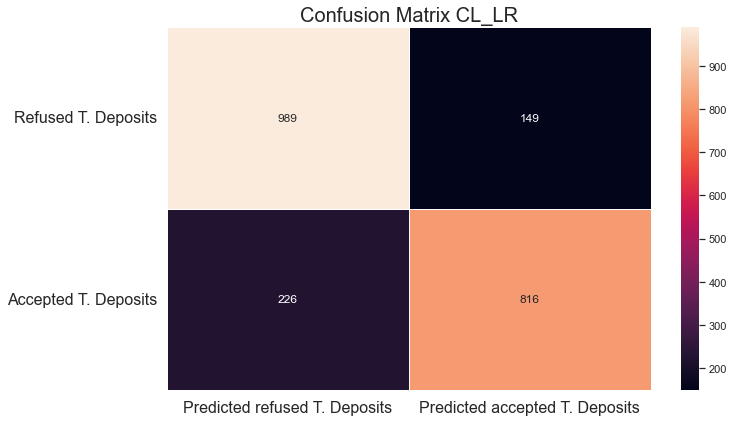

In [15]:
cl_LR_pred = cl_LR.predict(X_test)
# les probas du modèle
probs = cl_LR.predict_proba(X_test)

pd.crosstab(y_test, cl_LR_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

from sklearn.metrics import confusion_matrix

conf_matrix_CL_LR = confusion_matrix(y_test, cl_LR_pred)
f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(conf_matrix_CL_LR, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix CL_LR", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix_CL_LR.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Predicted refused T. Deposits', 'Predicted accepted T. Deposits'], fontsize=16)
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show();

In [16]:
print("Le taux de bonnes prédictions pour le modèle de la Regression Logistique est :",cl_LR.score(X_test,y_test))
print("Accuracy score de la Régression Logistique sur l'entrainement : ",cl_LR.score(X_train, y_train))

Le taux de bonnes prédictions pour le modèle de la Regression Logistique est : 0.8279816513761468
Accuracy score de la Régression Logistique sur l'entrainement :  0.8231245698554714


**Pas d'overfitting pour ce modèle de régression logistique. (train_score ~= test_score).**

In [17]:
from sklearn.metrics import classification_report
cl_LR_cr = classification_report(y_test,cl_LR_pred)
print(cl_LR_cr)
# Le taux de vrai négatif est très bon : 87%. Le taux de vrai positif est également bon atteignant 78%.

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1138
           1       0.85      0.78      0.81      1042

    accuracy                           0.83      2180
   macro avg       0.83      0.83      0.83      2180
weighted avg       0.83      0.83      0.83      2180



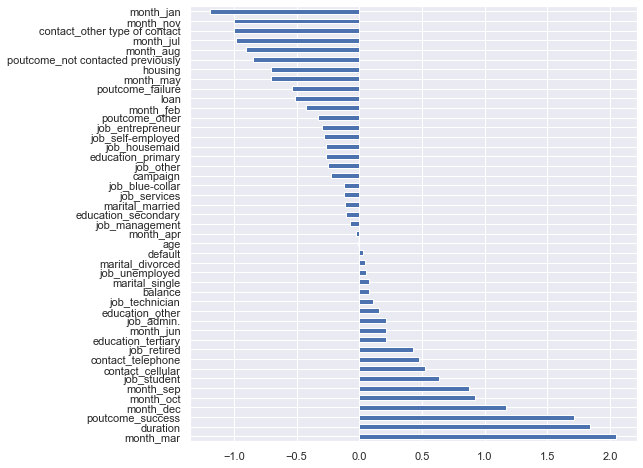

In [18]:
# Représentation graphique des coefficients de la régression logistique
pd.Series(cl_LR.coef_[0], X_train.columns).sort_values(ascending=False).plot(kind='barh', figsize=(8,8));

2 profil type se distinguent :
**-> Acceptation du DaT bancaire : Les étudiants et les retraités, ayant reçu un contact : telephone ou cellular d'une longue durée pour les mois de Mars, Septembre, Octobre ou Décembre ainsi que les personnes ayant déjà accepté un précédent DaT bancaire (poutcome = success).**

**Refus du DaT bancaire : Les personnes ayant un crédit immobilier ou un emprunt bancaire, ayant refusé le précédent DaT bancaire ou n'ayant pas été contacté précédemment et ayant été contacté pour cette campagne par un autre type de contact (other than telephone or cellular) en Janvier, Mai, Juillet, Août ou Novembre.**

**Le modèle régression Logistique bénéficie d'un bon taux de prédictions global. De plus, l'interprétabilité du modèle est excellente et confirme les hypothèses de la dataviz.**

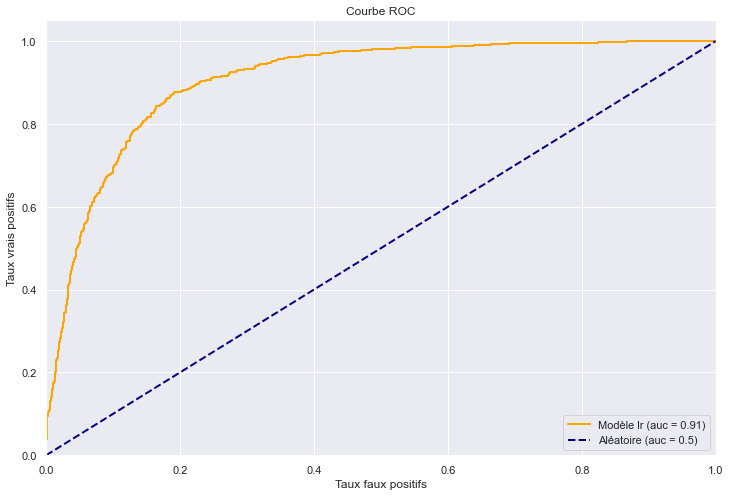

In [19]:
#COURBE ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Graph de la courbe ROC
plt.figure(figsize = (12, 8))
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle lr (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

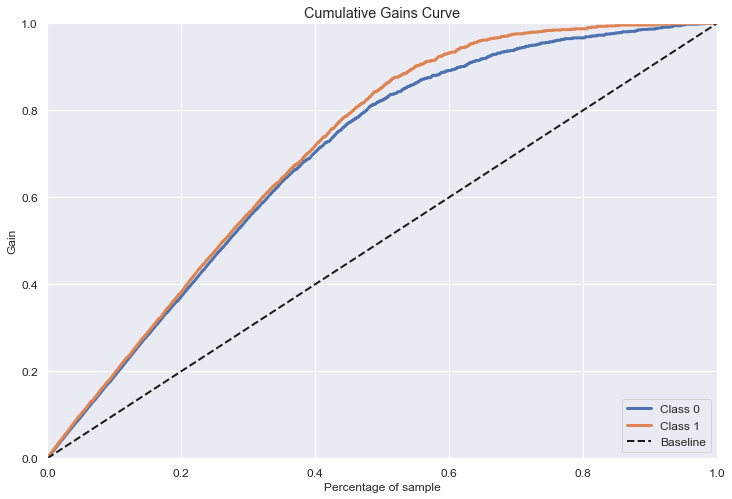

In [20]:
# Courbe de Lift ou courbe de gain
!pip install scikit-plot
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, probs, figsize=(12,8))
plt.show()

**Le score obtenu par le rappel de la classe positive (= taux de vrais positifs) est d'environ 4/5 (78%). Il s'agit du seuil que nous cherchons à estimer le mieux possible pour cette campagne marketing. Nous allons étudier la performance du second modèle selectionné :**

* b) Forêt aléatoire : interprétation du modèle

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Utilisation des meilleures paramètres ciblés précédemment
cl_RFC=RandomForestClassifier(min_samples_leaf=3, n_estimators=250, max_features='sqrt')
cl_RFC.fit(X_train, y_train)
# Enregistrement du modèle (pour streamlit)
dump(cl_RFC, 'cl_RFC_final.joblib') 

['cl_RFC_final.joblib']

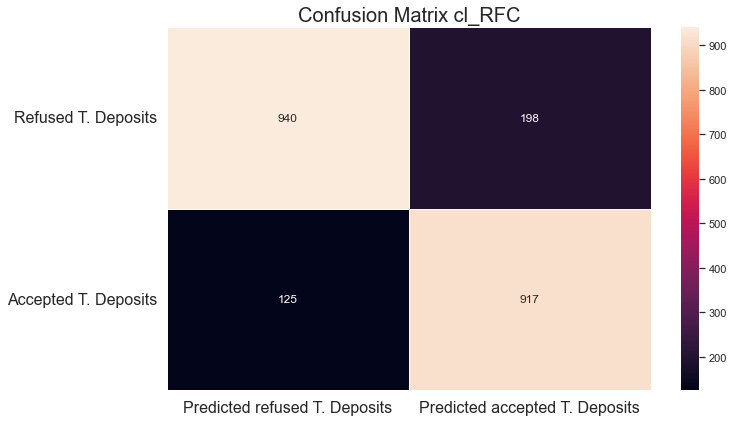

In [22]:
cl_RFC_pred = cl_RFC.predict(X_test)
# les probas du modèle
probs = cl_RFC.predict_proba(X_test)

pd.crosstab(y_test, cl_RFC_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

from sklearn.metrics import confusion_matrix

conf_matrix_cl_RFC = confusion_matrix(y_test, cl_RFC_pred)
f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(conf_matrix_cl_RFC, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix cl_RFC", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix_cl_RFC.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Predicted refused T. Deposits', 'Predicted accepted T. Deposits'], fontsize=16)
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show();

In [23]:
print("Le taux de bonnes prédictions pour le modèle de la Foret aléatoire est :",cl_RFC.score(X_test,y_test))

Le taux de bonnes prédictions pour le modèle de la Foret aléatoire est : 0.8518348623853211


In [24]:
print("Accuracy score de la Foret aléatoire sur l'entrainement :",cl_RFC.score(X_train,y_train))

Accuracy score de la Foret aléatoire sur l'entrainement : 0.9120211057582014


**Légère présence d'overfitting pour ce modèle de Forêt Aléatoire (train_score > test_score).**

In [25]:
from sklearn.metrics import classification_report
cl_RFC_cr = classification_report(y_test,cl_RFC_pred)
print(cl_RFC_cr)
# Le taux de vrai négatif est bon : 83%. Le taux de vrai positif est excellent atteignant 88%.

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1138
           1       0.82      0.88      0.85      1042

    accuracy                           0.85      2180
   macro avg       0.85      0.85      0.85      2180
weighted avg       0.85      0.85      0.85      2180



**Le modèle de Forêt aléatoire avec le paramètre 'min_samples_leaf' à 3 semble pertinent : meilleure performance globale (85%) et temps d'entraînement correct.
De plus, le score obtenu par le rappel de la classe positive (= taux de vrais positifs) est supérieur au modèle précédent 88%.
Son interprétabilité est plus complexe mais nous allons la détailler ci-dessous.**

In [26]:
# Affichage des 10 variables les plus importantes avec .feature_importances_

In [27]:
#feats = df_classification.drop('deposit', axis=1)
feature_names = feats.columns

feature_names

Index(['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_other', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_other', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular',
       'contact_other type of contact', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_not contacted previously',
       'poutcome_other', 'poutcome_success'],
      dtype='object')

Elapsed time to compute the importances: 0.014 seconds


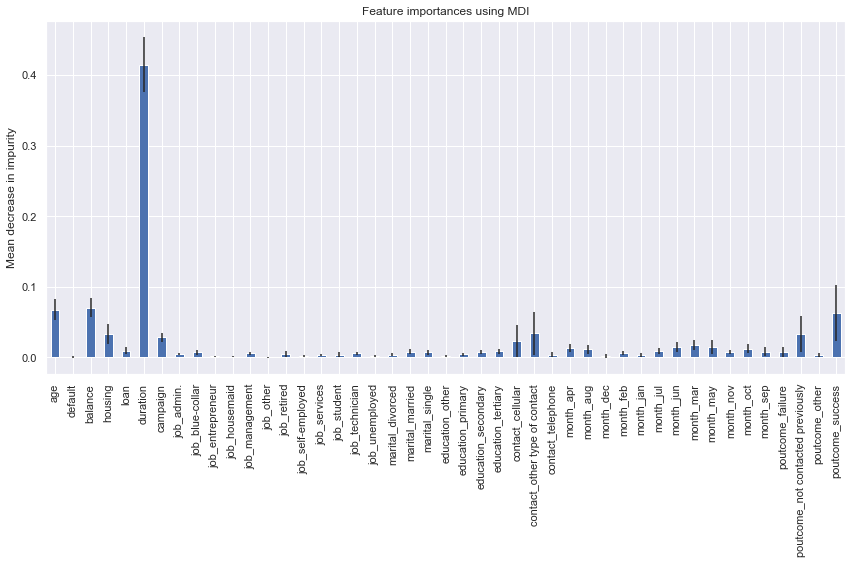

In [28]:
import time

start_time = time.time()
importances = cl_RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in cl_RFC.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

cl_RFC_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12,8))
cl_RFC_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [29]:
feats_imp = {}
for feature, importance in zip(feats.columns, cl_RFC.feature_importances_): 
    feats_imp[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats_imp, orient='index',columns=['Importance'])
importances.sort_values(by='Importance', ascending=False)

,Importance
duration,0.414697
balance,0.070513
age,0.067861
poutcome_success,0.063241
contact_other type of contact,0.034328
housing,0.032949
poutcome_not contacted previously,0.032762
campaign,0.028487
contact_cellular,0.023117
month_mar,0.017360


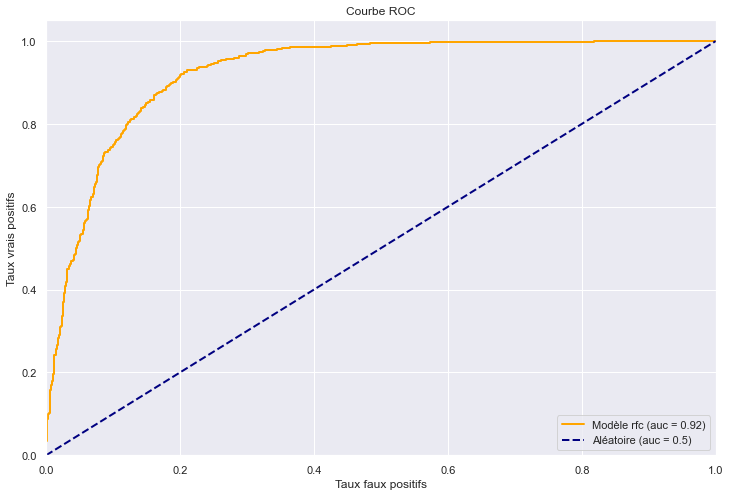

In [30]:
# les probas du modèle
probs = cl_RFC.predict_proba(X_test)

#COURBE ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Graph de la courbe ROC
plt.figure(figsize = (12, 8))
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle rfc (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

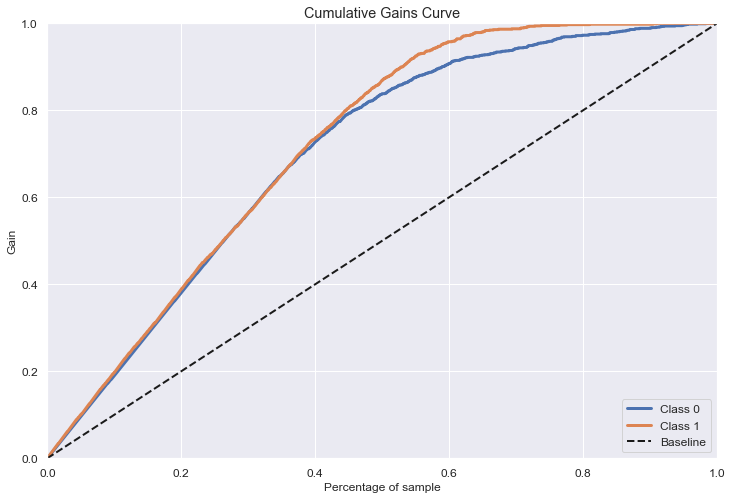

In [31]:
# Courbe de Lift ou courbe de gain
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, probs, figsize=(12,8))
plt.show()

**Les variables clés de ce modèle de forêt aléatoire permettant d'expliquer le plus l'acceptation ou non du DaT bancaire sont : duration, balance, age, poutcome, housing, contact & campaign.**

**L'interprétabilité et la légère présence d'overfitting sont les seuls inconvénients par rapport à la régression logistique.**

In [32]:
import session_info
session_info.show()